## 8. Futures Mean-Reversion Model
One of the common outcomes observed in trend-following models is that positions often get stopped out just before the market resumes moving in the direction of the original trend. This isn’t a bug in the strategy—it’s a structural feature. At some point, any trend-based model has to define when to cut a position that’s moving against it. We can adjust the stop distance, but doing so just changes the timeframe and doesn’t eliminate the issue.

The pattern is persistent enough to consider whether there’s a systematic effect behind it. One hypothesis is that the collective size of assets under management in trend-following strategies has introduced some feedback into price behavior. What started as a passive approach reacting to price may now be part of what drives it. Most trend-followers are using similar inputs—momentum filters, volatility-adjusted sizing, and trailing exits—so their actions tend to cluster in time.

If trend-followers are largely long and price begins to fall, some will start exiting. That can drive price further down, hitting more stop levels in the process. The result can be an exaggerated pullback, not necessarily because of new fundamental information but because of synchronized position reductions.

Once the pressure from those exits is exhausted, prices often bounce back. It’s this kind of overshoot-and-revert dynamic that creates an opportunity for a mean-reversion model. The idea isn’t to fight the trend, but to step in near levels where forced selling may have run its course.

### 8.1. Trading Logic and Pullbacks Measurement

This model buys moderate pullbacks inside an uptrend and exits quickly if the pullback deepens. It trades only when the 252-day rolling Sortino exceeds 1 (long-only, target return 0), so we avoid dip-buying in regimes dominated by harmful downside moves. Pullbacks are scaled by recent volatility using a 20-day mean and standard deviation of closes: let $\mu_{20}$ be the 20-day mean and $\sigma_{20}$ the 20-day standard deviation. 

The “pullback zone” is
$$
\mu_{20}-2\sigma_{20} \;\le\; \text{Close}_t \;\le\; \mu_{20},
$$
and the hard stop is at
$
\mu_{20}-3\sigma_{20}.
$

An entry on day $t$ requires all three:

- $\text{Sortino}_{252} > 1$; 

- price in the pullback zone (as defined above); and 

- EMA-5 rising, i.e., $\text{EMA5}_t>\text{EMA5}_{t-1}$

There is no profit target. The exit is a trailing stop: we close the position on a daily close below the trailing lower 3σ band computed from a 20-day Bollinger setup as in the trend-following model. The stop level is adjusted each day as  

$$
\text{Stop}_t = \max(\text{Stop}_{t-1},\, \text{BB}_{L,20,3,t}),
$$

so it can tighten but never loosen while the trade is open.


Sizing is equal risk per market. Contracts are set by

$$
\text{Contracts}=\frac{\text{Portfolio Value}\times \text{risk\_factor}}
{(\text{Close}_t-(\mu_{20}-3\sigma_{20}))\times \text{contract multiplier}},
$$

so each trade carries comparable dollar risk based on its own volatility. (This normalizes risk per instrument; portfolio-level correlations are handled elsewhere.)

Parameter choices are deliberately simple and robust: a 20-day window captures current volatility without chasing noise; the 2σ/3σ thresholds are transparent—moving them slightly (e.g., 1.5–2.5σ for entry or 2.5–3.5σ for the stop) does not change the model’s character; and the EMA-5 slope is a minimal confirmation that the pullback is easing. 

Figure 8 illustrates the pattern in the DAX future (FDAX): entries occur within the 2σ zone in acceptable regimes, and exits cut quickly on a 3σ break. The sleeve is narrow by design and complements the trend model rather than competing with it.

[2025-11-17 10:46:12.865217] INFO: Norgate Data: NorgateData package v1.0.74: Init complete


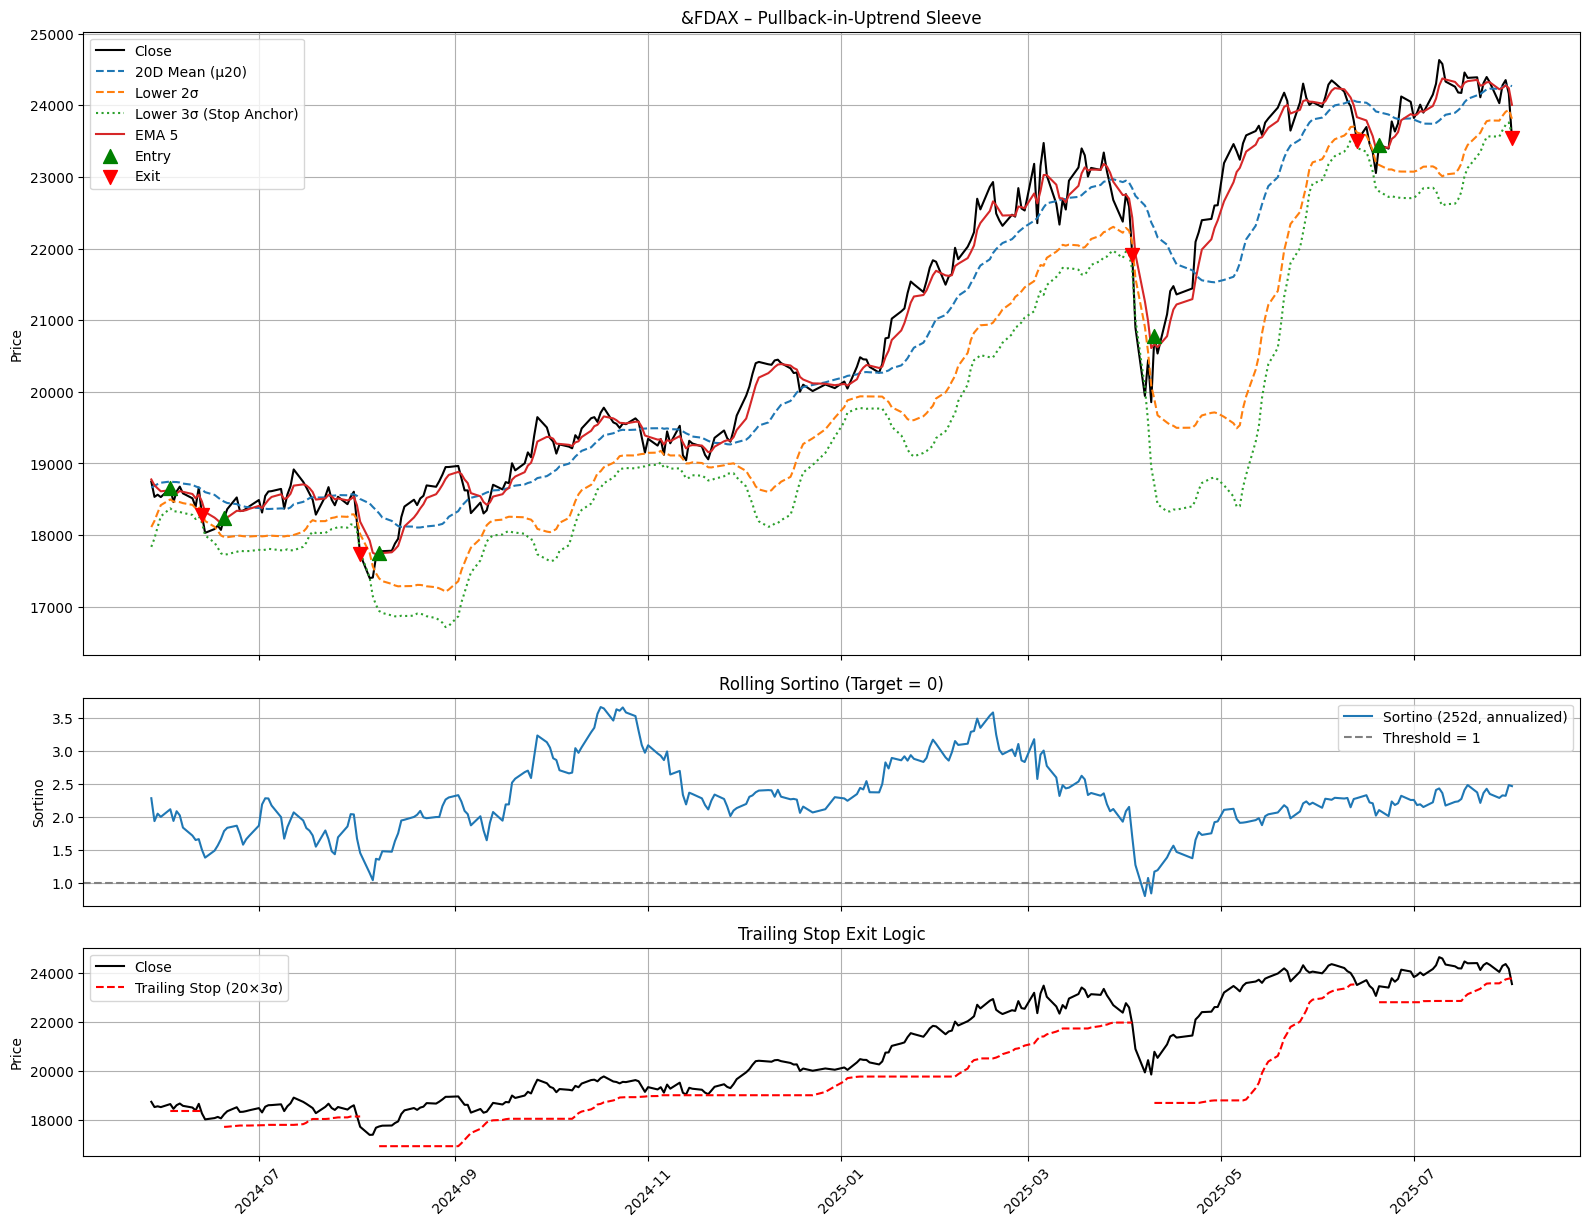

In [1]:
import norgatedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Parameters
# -----------------------
symbol = '&FDAX'
start_date = '2023-06-01'
end_date = '2025-08-01'
sortino_window = 252
entry_sigma = 2.0
stop_sigma = 3.0
annualize = True  # annualize Sortino for the >1 threshold
sortino_threshold = 1.0  # require Sortino(252, annualized) > 1

# -----------------------
# Fetch data
# -----------------------
df = norgatedata.price_timeseries(
    symbol,
    start_date=start_date,
    end_date=end_date,
    format='pandas-dataframe',
    stock_price_adjustment_setting=norgatedata.StockPriceAdjustmentType.NONE,
    padding_setting=norgatedata.PaddingType.NONE,
    timezone='UTC'
).dropna(subset=['Close'])

# -----------------------
# Indicators
# -----------------------
# EMA-5 (for rising check)
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()

# 20-day mean & std; Bollinger lower bands for 2σ and 3σ
df['MU_20'] = df['Close'].rolling(window=20).mean()
df['SIG_20'] = df['Close'].rolling(window=20).std()
df['BB_LOWER_2'] = df['MU_20'] - entry_sigma * df['SIG_20']
df['BB_LOWER_3'] = df['MU_20'] - stop_sigma  * df['SIG_20']

# 252-day rolling Sortino (target 0, annualized)
rets = df['Close'].pct_change()

def rolling_sortino(x, target=0.0):
    excess = x - target
    downside = np.minimum(excess, 0.0)
    dd = np.sqrt((downside**2).mean())
    if dd == 0 or np.isnan(dd):
        return np.nan
    return excess.mean() / dd

df['Sortino_252_raw'] = rets.rolling(window=sortino_window).apply(rolling_sortino, raw=False)
if annualize:
    df['Sortino_252'] = df['Sortino_252_raw'] * np.sqrt(252)
else:
    df['Sortino_252'] = df['Sortino_252_raw']

# Rising EMA-5 flag
df['EMA5_Rising'] = df['EMA_5'].diff() > 0

# -----------------------
# Trading logic
# -----------------------
df['Position'] = 0
df['Entry'] = False
df['Exit'] = False
df['Trailing_Stop'] = np.nan

in_trade = False
last_stop = np.nan

for i in range(len(df)):
    # warm-up: need Sortino available (i.e., at least 252 observations)
    if not np.isfinite(df['Sortino_252'].iloc[i]):
        continue

    row = df.iloc[i]

    # --- Entry ---
    if not in_trade:
        # price in pullback zone: MU_20 - 2σ <= Close <= MU_20
        in_zone = (row['Close'] >= row['BB_LOWER_2']) and (row['Close'] <= row['MU_20'])
        sortino_ok = row['Sortino_252'] > sortino_threshold
        ema5_rising = bool(row['EMA5_Rising'])

        entry_signal = in_zone and sortino_ok and ema5_rising

        if entry_signal:
            in_trade = True
            # initialize trailing stop at current 3σ lower band
            last_stop = row['BB_LOWER_3']
            df.iat[i, df.columns.get_loc('Entry')] = True
            df.iat[i, df.columns.get_loc('Trailing_Stop')] = last_stop

    # --- Exit / Manage trailing stop ---
    else:
        current_stop = row['BB_LOWER_3']  # daily 20×3σ lower band
        last_stop = max(last_stop, current_stop)  # ratchet only upward (tighten)
        df.iat[i, df.columns.get_loc('Trailing_Stop')] = last_stop

        if row['Close'] < last_stop:
            in_trade = False
            df.iat[i, df.columns.get_loc('Exit')] = True
            last_stop = np.nan

    df.iat[i, df.columns.get_loc('Position')] = int(in_trade)

# -----------------------
# Plotting (start after warm-up)
# -----------------------
plot_df = df[df['Sortino_252'].notna()].copy()

fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}
)

# 1) Price & signals
ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df.index, plot_df['MU_20'], label='20D Mean (μ20)', linestyle='--')
ax1.plot(plot_df.index, plot_df['BB_LOWER_2'], label='Lower 2σ', linestyle='--')
ax1.plot(plot_df.index, plot_df['BB_LOWER_3'], label='Lower 3σ (Stop Anchor)', linestyle=':')
ax1.plot(plot_df.index, plot_df['EMA_5'], label='EMA 5')
ax1.scatter(plot_df[plot_df['Entry']].index, plot_df[plot_df['Entry']]['Close'],
            color='green', marker='^', s=100, label='Entry', zorder=5)
ax1.scatter(plot_df[plot_df['Exit']].index, plot_df[plot_df['Exit']]['Close'],
            color='red', marker='v', s=100, label='Exit', zorder=5)
ax1.set_title(f'{symbol} – Pullback-in-Uptrend Sleeve')
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# 2) Sortino (252d, annualized) with threshold line at 1
ax2.plot(plot_df.index, plot_df['Sortino_252'], label='Sortino (252d, annualized)')
ax2.axhline(sortino_threshold, linestyle='--', color='gray', label='Threshold = 1')
ax2.set_ylabel('Sortino')
ax2.set_title('Rolling Sortino (Target = 0)')
ax2.grid(True)
ax2.legend()

# 3) Trailing stop track
ax3.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax3.plot(plot_df.index, plot_df['Trailing_Stop'], label='Trailing Stop (20×3σ)', linestyle='--', color='red')
ax3.set_ylabel('Price')
ax3.set_title('Trailing Stop Exit Logic')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

_Figure 8 - Mean Reversion Strategy Representation_

### 8.2. Mean-Reversion Model Source Code
Here we keep the same infrastructure as the trend-following model: universe construction, data handling, cost/slippage settings, risk-based sizing, the liquidity cap, correlation and Sortino parameters, roll management, and reporting. The only change is the trading logic (when we enter and when we exit). The code below is a drop-in replacement for the earlier `daily_trade` function; everything else in the framework remains unchanged

In [ ]:
%matplotlib inline
import os
import zipline
from zipline.api import future_symbol,  \
    set_commission, set_slippage, schedule_function, date_rules, \
    time_rules, continuous_future, order_target, symbol, set_benchmark
from pandas import Timestamp
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np  
from zipline.finance.commission import PerTrade, PerContract
from zipline.finance.slippage import VolumeShareSlippage, \
    FixedSlippage, VolatilityVolumeShare
import sys
from pprint import pprint,pformat
import json
import norgatedata

# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets
out = widgets.HTML()
display(out)

from zipline_norgatedata import register_norgatedata_futures_bundle


"""
Model Settings
"""
# ASSETS TO TRADE IN PORTFOLIO:
SELECTED_SYMBOLS = [
        # Currency
        'BTC', # Bitcoin OK 
        'DX', # US Dollar Index OK 
        'ETH', # Ether OK
        

        # Agriculture & Livestock
        'CC', # Cocoa OK
        'CT', # Cotton No. 2 OK
        'DC', # Class III Milk OK
        'GF', # Feeder Cattle OK
        'HE', # Lean Hogs OK
        'KC', # Coffee C OK
        'LBR', # Lumber OK
        'LE', # Live Cattle OK
        'LSU', # White Sugar OK
        'OJ', # Orange Juice OJ OK
        'RS', # Canola OK
        'SB', # Sugar No. 11 OK
        'ZC', # Corn OK
        'ZL', # Soybean Oil OK
        'ZM', # Soybean Meal OK
        'ZO', # Oats OK
        'ZR', # Rough Rice ZR OK
        'ZS', # Soybeans OK
        'ZW', # SRW Wheat OK

        # Interest Rate
        'CGB', # Canada Bond OK
        'FBTP', # Euro-BTP OK 
        'FGBL', # Euro-Bund OK
        'FGBM', # Euro-Bobl OK
        'FGBS', # Euro-Schatz OK
        'FGBX', # Euro-Buxl OK 
        'FOAT', # Euro-OAT OK
        'LLG', # Long Gilt OK
        'SJB', # JGB Mini OK
        'TN', # Ultra 10Y Note OK
        'UB', # Ultra T-Bond OK
        'YXT', # ASX 10Y Bond OK 
        'YYT', # ASX 3Y Bond OK
        'ZB', # 30Y T-Bond OK
        'ZF', # 5Y T-Note OK
        'ZN', # 10Y T-Note OK
        'ZT', # 2Y T-Note OK

        # Stock Index
        'EMD', # E-mini MidCap 400
        'ES', # E-mini S&P 500
        'FCE', # CAC 40
        'FDAX', # DAX
        'FESX', # EURO STOXX 50
        'FSMI', # Swiss Market Index
        'FTDX', # TecDAX
        'HSI', # Hang Seng Index
        'HTW', # MSCI Taiwan
        'KOS', # KOSPI 200
        'LFT', # FTSE 100
        'NKD', # Nikkei 225 Dollar
        'NQ', # E-mini Nasdaq-100
        'RTY', # E-mini Russell 2000
        'SCN', # FTSE China A50
        'SSG', # MSCI Singapore
        'SXF', # S&P/TSX 60
        'YAP', # ASX SPI 200
        'YM', # E-mini Dow

        # Energy
        'BRN', # Brent Crude
        'CL', # Crude Oil
        'GAS', # Gas Oil
        'GWM', # UK Natural Gas
        'HO', # NY Harbor ULSD
        'NG', # Natural Gas
        'RB', # RBOB Gasoline
        'WBS', # WTI Crude

        # Metal
        'GC', # Gold
        'HG', # Copper
        'PA', # Palladium
        'PL', # Platinum
        'SI', # Silver
]
starting_portfolio = 10000000
risk_factor = 0.005 #RISK FACTOR: Fraction of capital risked per trade, drives position sizing and stop logic
vola_window = 20 #VOLA WINDOW: Loockback to calculate volatility, drives position sizing and stop logic
enable_commission = True
enable_slippage = True  

#LIQUIDITY FILTER: Only trade instruments whose 5-day average daily volume exceeds 100 contracts
min_avg_vol = 100 
avg_vol_window = 5


def report_result(context, data): #Function used to update live HTML reporting 
    context.months += 1 #Keeps track of the number of months simulated
    today = zipline.api.get_datetime().date() #Retrives the current simulation date
    # Computes annualized return from the beginning of the backtest
    ann_ret = np.power(context.portfolio.portfolio_value / starting_portfolio, 
                   12 / context.months) - 1
    
    # Update the text
    out.value = """{} We have traded <b>{}</b> months 
    and the annualized return is <b>{:.2%}</b>""".format(today, context.months, ann_ret)

def roll_futures(context, data): #This function ensures that expiring futures positions are rolled into the next active contract, maintaining a continuous exposure
    open_orders = zipline.api.get_open_orders() #get a dictionary of all pending orders in the simulation, used to avoid duplicating actions for contracts already being traded in this bar
    
    for held_contract in context.portfolio.positions: #loop through currently held contracts
        # don't roll positions that are set to change by core logic
        if held_contract in open_orders: #if there's already an order in-flight, skip rolling to avoid conflict with your core trading logic
            continue
        
        # auto_close_date is when Zipline will forecefully close the position to simulate expiry, data.current_session gives the current trading date
        # compute how many days are left until forced close
        days_to_auto_close = (
            held_contract.auto_close_date.date() - data.current_session.date()
        ).days

        #only roll contracts if they're 5 or fewer trading days from expiry, prevents unnecessary rolling
        if days_to_auto_close > 5:
            continue        
        
        # Make a continuation, get the current front-month continuous future
        #offset=0 use front contract
        #roll='volume' roll to next contract when volume surpasses current
        #adjustment='mul' price-adjust using multiplicative factor (prevents artificial PnL jumps on roll)
        continuation = continuous_future(
                held_contract.root_symbol, 
                offset=0, 
                roll='volume', 
                adjustment='mul'
                )
        
        # Pull the actual active futures contract from the continuation series
        continuation_contract = data.current(continuation, 'contract')
        
        if continuation_contract != held_contract:# If the current position is not in the new front contract, we need to roll it
            # Determine the number of contracts currently held in the expiring future
            pos_size = context.portfolio.positions[held_contract].amount         
            # Close current position
            order_target(held_contract, 0)
            # Open the same position size in the new active contract
            order_target(continuation_contract, pos_size)     
            
def position_size(portfolio_value, stop_distance, point_value): #This function calculates how many contracts to buy or sell based on volatility targeting - a core principle in risk-parity and trend-following
    target_variation = portfolio_value * risk_factor #Dollar value of risk you are willing to take on this trade
    contract_variation = stop_distance * point_value #contract volatility in $ temrs:
    #std volatility estimate (eg 20day standard deviation of daily prices)
    #point_value the dollar value of 1 point of movment in the contract (ES futures, 1 point =$50)
    contracts = target_variation / contract_variation #divide dollar risk allowd  by risk per contract to get the number of contracts, ensures every trade contributes equally to total risk, adjusted for volatility
    return int(np.nan_to_num(contracts)) #Returns the integer number of contracts:
    #nan_to_num if input was invalid (NaN), it returns 0
    #int: no fractional contracts allowed in futures

def initialize(context):
    set_benchmark(symbol('$SPXTR'))    

    """
    Cost Settings
    """
    if enable_commission:
        comm_model = PerContract(cost=0.85, exchange_fee=1.5)
    else:
        comm_model = PerTrade(cost=0.0)
    set_commission(us_futures=comm_model)

    if enable_slippage:
        slippage_model = VolatilityVolumeShare(volume_limit=0.2)
    else:
        slippage_model = FixedSlippage(spread=0.0)      
    set_slippage(us_futures=slippage_model) 

    """
    Markets to trade (filtered by SELECTED_SYMBOLS)
    """ 
    af = context.asset_finder
    allcontracts = af.retrieve_futures_contracts(af.futures_sids)

    markets = set()
    for contract in allcontracts.values():
        root = contract.root_symbol
        if root != '' and root in SELECTED_SYMBOLS:
            markets.add(root)

    markets = sorted(list(markets))

    context.universe = [
        continuous_future(m, offset=0, roll='volume', adjustment='mul')
        for m in markets
    ]

    context.highest_in_position = {m: 0 for m in markets}
    context.lowest_in_position = {m: 0 for m in markets}    

    schedule_function(daily_trade, date_rules.every_day(), time_rules.market_close())

    context.months = 0    

    schedule_function(
        func=report_result,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )

    
def analyze(context, perf): #runs after the backtest completes and generates a performance tear sheet using Pyfolio, comparing the strategy to the benchamrk
    #extract the key outputs from the perf dictionary
    #returns: daily returns of your strategy
    #positions: holdings over time
    #transactions: trade-level execution data
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    # Save to CSV
    start_str = start_date.strftime("%Y-%m-%d")
    end_str = end_date.strftime("%Y-%m-%d")
    output_dir = r"C:\Users\Juanan\Downloads\CQF\2.Mean_Reversion\1.Zipline_Trades\1.Full_Backtest"
    os.makedirs(output_dir, exist_ok=True)

    
    returns_filename = os.path.join(output_dir, f"returns_{start_str}_to_{end_str}_MR.csv")
    positions_filename = os.path.join(output_dir, f"positions_{start_str}_to_{end_str}_MR.csv")
    transactions_filename = os.path.join(output_dir, f"transactions_{start_str}_to_{end_str}_MR.csv")
    returns.to_csv(returns_filename)
    positions.to_csv(positions_filename)
    transactions.to_csv(transactions_filename)
    
    #pulls benchmark data
    spxtr = norgatedata.price_timeseries(
        '$SPXTR',
        start_date = returns.index[0],
        end_date = returns.index[-1],
        format='pandas-dataframe',
        timezone='UTC',
    )
    #converts the benchmark price series into daily returns (percentage change) and drops first NaN
    spxtr_rets = spxtr['Close'].pct_change().dropna()
    spxtr_rets.name = '$SPXTR'
    
    # The following supresses all warnings - mainly because there is some code within pyfolio, 
    # empyrical, pandas and matplotlib that has deprecated calls - this just supresses the
    # warnings from showing
    import warnings
    warnings.filterwarnings('ignore')

    #standard institutional-level summary of strategy performance
    pf.create_returns_tear_sheet(returns, benchmark_rets=spxtr_rets)
    # Generate the full performance tear sheet
    #pf.create_full_tear_sheet(
        #returns=returns,
        #benchmark_rets=spxtr_rets,
        #positions=positions,
        #transactions=transactions,
        #round_trips=True
    #)
    
def daily_trade(context, data):
    """
    Core daily logic:
      - Build history & indicators
      - Liquidity filter
      - Correlation filter vs existing positions
      - Sortino filter (downside deviation vs TARGET_RETURN)
      - Stop-distance-based sizing
      - Entry: mean-reversion logic with Bollinger Band and EMA(5)
      - Exit: BB(20, 3σ) trailing stop
      - Contract roll handling
    """

    try:
        SORTINO_THRESHOLD
    except NameError:
        SORTINO_THRESHOLD = 1.0
    try:
        ANNUALIZE_SORTINO
    except NameError:
        ANNUALIZE_SORTINO = True
    try:
        TARGET_RETURN
    except NameError:
        TARGET_RETURN = 0.0

    hist = data.history(
        context.universe,
        fields=['close', 'volume'],
        frequency='1d',
        bar_count=250,
    )

    hist['avg_vol'] = hist['volume'].rolling(avg_vol_window).mean()

    open_pos = {pos.root_symbol: pos for pos in context.portfolio.positions}

    for continuation in context.universe:
        if context.datetime.tz_localize(None) < continuation.start_date:
            continue

        root = continuation.root_symbol
        h = hist.xs(continuation, level=1)

        # === Indicators for mean-reversion ===
        h['ema_5'] = h['close'].ewm(span=5).mean()
        h['ema_5_rising'] = h['ema_5'].diff() > 0
        h['bb_basis_20'] = h['close'].rolling(20).mean()
        h['bb_std_20'] = h['close'].rolling(20).std()
        h['bb_lower_20_2'] = h['bb_basis_20'] - 2 * h['bb_std_20']
        h['bb_lower_20_3'] = h['bb_basis_20'] - 3 * h['bb_std_20']

        # === Exit logic ===
        if root in open_pos:
            contract = open_pos[root]

            if context.lowest_in_position[root] == 0:
                context.lowest_in_position[root] = h['bb_lower_20_3'].iloc[-1]
            else:
                context.lowest_in_position[root] = max(
                    context.lowest_in_position[root],
                    h['bb_lower_20_3'].iloc[-1]
                )

            trailing_stop = context.lowest_in_position[root]
            if h['close'].iloc[-1] < trailing_stop:
                order_target(contract, 0)
                context.lowest_in_position[root] = 0

        # === Entry logic ===
        else:
            close = h['close'].iloc[-1]
            basis = h['bb_basis_20'].iloc[-1]
            lower2 = h['bb_lower_20_2'].iloc[-1]

            entry_signal = (
                lower2 < close < basis and
                h['ema_5_rising'].iloc[-1]
            )

            if not entry_signal:
                continue

            contract = data.current(continuation, 'contract')
            if contract is None:
                continue

            stop_distance = close - h['bb_lower_20_3'].iloc[-1]
            if stop_distance <= 0 or np.isnan(stop_distance):
                continue

            contracts_to_trade = position_size(
                context.portfolio.portfolio_value,
                stop_distance,
                contract.price_multiplier
            )

            vol20 = h['volume'][-20:].mean()
            contracts_cap = int(vol20 * 0.2) if vol20 == vol20 else 0
            contracts_to_trade = max(0, min(contracts_to_trade, contracts_cap))

            if h['avg_vol'].iloc[-1] < min_avg_vol or contracts_to_trade <= 0:
                continue

            # === Correlation Filter ===
            corr_window = 60
            eligible_to_trade = True
            try:
                new_close = data.history(continuation, fields='close', bar_count=corr_window, frequency='1d')
                new_returns = new_close.pct_change().dropna()
            except Exception:
                eligible_to_trade = False

            if eligible_to_trade and len(open_pos) > 0:
                for held_symbol, held_contract in open_pos.items():
                    held_continuation = continuous_future(held_symbol, offset=0, roll='volume', adjustment='mul')
                    try:
                        held_close = data.history(held_continuation, fields='close', bar_count=corr_window, frequency='1d')
                        held_returns = held_close.pct_change().dropna()
                    except Exception:
                        continue

                    min_len = min(len(held_returns), len(new_returns))
                    if min_len < 5:
                        continue

                    corr = np.corrcoef(new_returns[-min_len:], held_returns[-min_len:])[0, 1]
                    if corr > 0.9:
                        eligible_to_trade = False
                        break

            if not eligible_to_trade:
                continue

            # === Sortino Filter ===
            try:
                sortino_window = 252
                sortino_close = data.history(continuation, fields='close', bar_count=sortino_window, frequency='1d')
                rets = sortino_close.pct_change().dropna()
                excess = rets - TARGET_RETURN
                downside = np.minimum(excess, 0.0)
                downside_dev = np.sqrt((downside ** 2).mean())

                if downside_dev == 0 or np.isnan(downside_dev):
                    sortino = -np.inf
                else:
                    sortino = excess.mean() / downside_dev
                    if ANNUALIZE_SORTINO:
                        sortino *= np.sqrt(252)

                if sortino > SORTINO_THRESHOLD:
                    order_target(contract, contracts_to_trade)
                    context.lowest_in_position[root] = h['bb_lower_20_3'].iloc[-1]

            except Exception:
                pass

    # === Contract Roll Logic ===
    if len(open_pos) > 0:
        roll_futures(context, data)


# Start date fixed as historical anchor
start_date = Timestamp('2001-12-28')
# End date = today (previous trading day in UTC to match Norgate bars)
end_date = Timestamp('2025-08-12')


# Turn off all warnings to make the output a little nicer:
import warnings
warnings.filterwarnings("ignore")

perf = zipline.run_algorithm(
    start=start_date, end=end_date, 
    initialize=initialize, 
    #before_trading_start=before_trading_start,
    analyze=analyze,
    capital_base=starting_portfolio,  
    data_frequency = 'daily', 
    bundle='norgatedata-full-futures',
    benchmark_returns=None,
) 

### 8.3. Mean-Reversion Model Results

The backtest confirms that a basic volatility-pullback model can produce acceptable performance under the right market conditions. While the stop-loss mechanism in this version is intentionally simple, the general pattern is clear: the strategy is responsive to sharp short-term dislocations in bullish regimes and tends to recover relatively quickly from drawdowns.

Table 3 shows the monthly and yearly returns for the mean-reversion strategy from 2001 to 2025. The results demonstrate considerable variation in performance across years, with periods of strong profitability—such as 2003, 2006, 2014, 2017 and 2019—interspersed with extended drawdown phases like 2007, 2011, and 2016. This behavior is consistent with a strategy that profits from short-term dislocations but is vulnerable during prolonged trends or volatile reversals.

In [ ]:
# Required in Jupyter Notebooks
%matplotlib inline

# 1. Imports
import pandas as pd
import empyrical as em
from IPython.display import display, HTML

# 2. Load your returns CSV file
file_path = r"C:\Users\Juanan\Downloads\CQF\2.Mean_Reversion\1.Zipline_Trades\1.Full_Backtest\returns_2001-12-28_to_2025-08-12_MR.csv"
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

# 3. Inspect available columns to confirm correct name
print("Columns found:", df.columns)

# 4. Replace 'returns' with your actual returns column name if different
returns_column = 'returns'  # <-- Change this if needed

# 5. Aggregate monthly and yearly returns using empyrical
monthly_data = em.aggregate_returns(df[returns_column], 'monthly')
yearly_data = em.aggregate_returns(df[returns_column], 'yearly')

# 6. Build the Monthly Returns Table in HTML
table = """
<table class='table table-hover table-condensed table-striped'>
<thead>
<tr>
<th style="text-align:right">Year</th>
<th style="text-align:right">Jan</th>
<th style="text-align:right">Feb</th>
<th style="text-align:right">Mar</th>
<th style="text-align:right">Apr</th>
<th style="text-align:right">May</th>
<th style="text-align:right">Jun</th>
<th style="text-align:right">Jul</th>
<th style="text-align:right">Aug</th>
<th style="text-align:right">Sep</th>
<th style="text-align:right">Oct</th>
<th style="text-align:right">Nov</th>
<th style="text-align:right">Dec</th>
<th style="text-align:right">Year</th>
</tr>
</thead>
<tbody>
<tr>
"""

first_year = True
first_month = True
yr = 0
mnth = 0

for m, val in monthly_data.items():
    yr = m[0]
    mnth = m[1]

    if first_month:
        table += "<td align='right'><b>{}</b></td>\n".format(yr)
        first_month = False

    if first_year:
        first_year = False
        if mnth > 1:
            for i in range(1, mnth):
                table += "<td align='right'>-</td>\n"

    table += "<td align='right'>{:+.1f}</td>\n".format(val * 100)

    if mnth == 12:
        table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
        table += "</tr>\n<tr>\n"
        first_month = True

# Final padding if last year doesn't end in December
if mnth != 12:
    for i in range(mnth + 1, 13):
        table += "<td align='right'>-</td>\n"
        if i == 12:
            table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
            table += "</tr>\n"

table += "</tbody></table>"

# 7. Display the table in notebook
display(HTML(table))

_Table 3 - Mean Reversion Monthly Returns_

Figure 9 shows the cumulative returns, drawdowns, and 12-month rolling correlation of the mean-reversion model against the S&P Total Return Index.

From a performance perspective, the model has produced steady gains over the full sample, compounding capital at a pace that stays competitive with equities, especially on a risk-adjusted basis. The log scale makes the equity curve more interpretable across decades and shows that while the strategy doesn’t trend consistently, it does recover from drawdowns and compounds over time.

Drawdown behavior (middle panel) reflects the nature of the system: mean-reversion strategies are exposed to clusters of small losses, especially when markets trend persistently without pullbacks. Notably, the strategy tends to hold up better during broad market corrections—avoiding deep drawdowns that are typical of long-only exposures.

The 12-month rolling correlation (bottom panel) confirms that the strategy operates largely independent of the equity benchmark. While there are short bursts of moderate correlation during periods of volatility, the correlation frequently drops toward zero—or even negative territory—especially during major equity drawdowns. This confirms that the strategy can serve as a diversifier, not just an alpha source.

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import norgatedata

# --- Load Strategy Returns ---
returns_file_path = r"C:\Users\Juanan\Downloads\CQF\2.Mean_Reversion\1.Zipline_Trades\1.Full_Backtest\returns_2001-12-28_to_2025-08-12_MR.csv"
returns_df = pd.read_csv(returns_file_path, index_col=0, parse_dates=True)
returns_df.index = returns_df.index.tz_localize(None)  # Remove timezone info

# --- Load $SPXTR Total Return Index from NorgateData ---
symbol = "$SPXTR"
spxtr_df = norgatedata.price_timeseries(
    symbol,
    start_date="2001-12-28",
    end_date="2025-08-01",
    format="pandas-dataframe",
    stock_price_adjustment_setting=norgatedata.StockPriceAdjustmentType.NONE,
    padding_setting=norgatedata.PaddingType.NONE,
    timezone="UTC"
)

# Clean and process SPXTR data
if spxtr_df.empty:
    raise ValueError(f"No data found for {symbol}")
spxtr_df = spxtr_df.dropna(subset=["Close"])
spxtr_df.index = spxtr_df.index.tz_convert(None)

# --- Align Strategy and Benchmark by Date ---
combined_df = pd.DataFrame(index=returns_df.index)
combined_df["strategy_returns"] = returns_df["returns"]
combined_df["spxtr_returns"] = spxtr_df["Close"].pct_change()
combined_df.dropna(inplace=True)

# --- Compute Cumulative Returns ---
combined_df["strategy_cum"] = (1 + combined_df["strategy_returns"]).cumprod()
combined_df["spxtr_cum"] = (1 + combined_df["spxtr_returns"]).cumprod()

# --- Compute Drawdowns ---
running_max = combined_df["strategy_cum"].cummax()
combined_df["drawdown"] = combined_df["strategy_cum"] / running_max - 1

# --- Compute 12-Month Rolling Correlation (252 Trading Days) ---
combined_df["rolling_corr_12m"] = (
    combined_df["strategy_returns"]
    .rolling(window=252)
    .corr(combined_df["spxtr_returns"])
)

# --- Clean Data for Plotting ---
plot_df = combined_df.dropna(subset=["drawdown", "rolling_corr_12m"]).copy()
plot_df.index = pd.to_datetime(plot_df.index).tz_localize(None)

# Convert for plotting
x_vals = plot_df.index.to_numpy()
drawdown_vals = plot_df["drawdown"].astype(np.float64).to_numpy()
rolling_corr_vals = plot_df["rolling_corr_12m"].astype(np.float64).to_numpy()

# --- Plot ---
fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True, constrained_layout=True)

# Cumulative Returns
axs[0].semilogy(x_vals, plot_df["strategy_cum"], label="Mean Reversion Strategy", color="black", linewidth=1.4)
axs[0].semilogy(x_vals, plot_df["spxtr_cum"], label="$SPXTR", color="gray", linewidth=1.2)
axs[0].legend(loc="upper left", frameon=True)
axs[0].set_ylabel("Cumulative Return (Log Scale)")
axs[0].set_title("Strategy Comparisons")

# Drawdown
axs[1].fill_between(x_vals, drawdown_vals, 0, color="black", alpha=0.9, label="Drawdown")
axs[1].legend(loc="lower left", frameon=True)
axs[1].set_ylabel("Drawdown")

# 12M Rolling Correlation
axs[2].fill_between(x_vals, rolling_corr_vals, 0, color="gray", alpha=0.8, label="12M Rolling Correlation")
axs[2].legend(loc="lower left", frameon=True)
axs[2].set_ylabel("Correlation")
axs[2].set_xlabel("Date")

plt.show()

_Figure 9 - Mean Reversion Model Equity Curve_

Table 4 summarizes the annualized returns of the mean-reversion strategy depending on the start year and holding period, giving a forward-looking sense of performance based on historical entry points.

Across almost all combinations, the model delivers double-digit annualized returns—typically between 10% and 13% for holding periods longer than five years. That’s a sign of a reliable return engine, not a system that only worked in a few lucky years.

Some start years, like 2009, 2012, and 2020, show outsized short-term returns. That’s expected. These were high-volatility regimes with lots of dislocations—the kind of environment where a reversion model has room to work. But even outside those ideal entry points, the returns don’t collapse. For example, starting in 2015 and holding for five years still gets you around 11% CAGR. That's resilience.

Lastly, there are very few red cells—almost no multi-year stretches where the strategy loses money. That matters. It tells you that while short-term drawdowns exist (as they should), longer-term capital exposure hasn't been punished historically. 

In [ ]:
import empyrical as em
import seaborn as sns
import matplotlib.pyplot as plt

# Use the strategy returns from earlier
strategy_daily_returns = combined_df['strategy_returns']
strategy_yearly_returns = em.aggregate_returns(strategy_daily_returns, 'yearly')

# Convert to a list for easier indexing
yr_list = strategy_yearly_returns.tolist()
yr_index = strategy_yearly_returns.index

# Initialize the DataFrame to store holding period returns
num_years = len(yr_list)
holding_matrix = pd.DataFrame(index=yr_index, columns=range(1, num_years + 1))

# Populate the holding period map
for start_idx in range(num_years):
    for years_held in range(1, num_years - start_idx + 1):
        sub_returns = yr_list[start_idx:start_idx + years_held]
        ann_return = em.annual_return(pd.Series(sub_returns), period='yearly')
        holding_matrix.iat[start_idx, years_held - 1] = ann_return * 100  # convert to %

# Trim unused columns and rows (NaN)
holding_matrix = holding_matrix.dropna(how='all').dropna(axis=1, how='all').astype(float)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(holding_matrix, annot=True, fmt="+.0f", cmap="RdYlGn", center=0, cbar_kws={'label': 'Annualized Return (%)'})
plt.title("Mean Reversion Strategy Annualized Return by Holding Period")
plt.xlabel("Years Held")
plt.ylabel("Starting Year")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

_Table 4 - Mean Reversion Holding Period Returns_

On its own, the strategy is adequate. But its real value is in how it interacts with trend-following models. The performance regimes tend to be complementary, and when combined, the two approaches can reduce portfolio-level drawdowns and smooth equity curve volatility. Further evaluation will focus on combining both models into a single portfolio allocation.